
## Load the data

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"
dataPath = '/content/drive/My Drive/credit/kaggle_credit/'

In [4]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [5]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes)
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [ ]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)

## Feature engineering



In [ ]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process A-type, P-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M","P"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M", "P"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['actualdpdtolerance_344P', 'amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avgdbddpdlast24m_3658932P', 'avgdbddpdlast3m_4187120P', 'avgdbdtollast24m_4525197P', 'avgdpdtolclosure24_3658938P', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgmaxdpdlast9m_3716943P', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdbddpdlast1m_3658939P', 'maxdbddpdtollast12m_3658940P', 'maxdbddpdtollast6m_4187119P', 'maxdebt4_972A', 'maxdpdfr

In [ ]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [ ]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['actualdpdtolerance_344P', 'amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avgdbddpdlast24m_3658932P', 'avgdbddpdlast3m_4187120P', 'avgdbdtollast24m_4525197P', 'avgdpdtolclosure24_3658938P', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgmaxdpdlast9m_3716943P', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdbddpdlast1m_3658939P', 'maxdbddpdtollast12m_3658940P', 'maxdbddpdtollast6m_4187119P', 'maxdebt4_972A', 'maxdpdfr

In [ ]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 70)
Valid: (305332, 70)
Test: (305332, 70)


## Training LightGBM



In [ ]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.742776
[100]	valid_0's auc: 0.759971
[150]	valid_0's auc: 0.767515
[200]	valid_0's auc: 0.771745
[250]	valid_0's auc: 0.774267
[300]	valid_0's auc: 0.775872
[350]	valid_0's auc: 0.777276
[400]	valid_0's auc: 0.7784
[450]	valid_0's auc: 0.779294
[500]	valid_0's auc: 0.77995
[550]	valid_0's auc: 0.780564
[600]	valid_0's auc: 0.781375
[650]	valid_0's auc: 0.781908
[700]	valid_0's auc: 0.782373
Early stopping, best iteration is:
[696]	valid_0's auc: 0.782388


Evaluation with AUC and then comparison with the stability metric is shown below.

In [ ]:
for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
    y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
    base["score"] = y_pred

print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["score"])}')
print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["score"])}')
print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')

The AUC score on the train set is: 0.792209066706691
The AUC score on the valid set is: 0.7823877168754692
The AUC score on the test set is: 0.7784630534469104


Visualizing the ROC curve

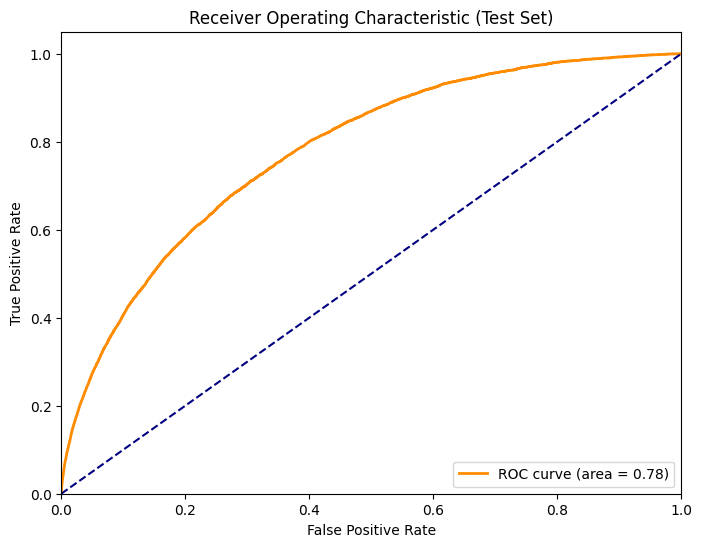

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'base_test' has the true labels and predicted scores
fpr, tpr, _ = roc_curve(base_test['target'], base_test['score'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.show()


Visualizing feature importance

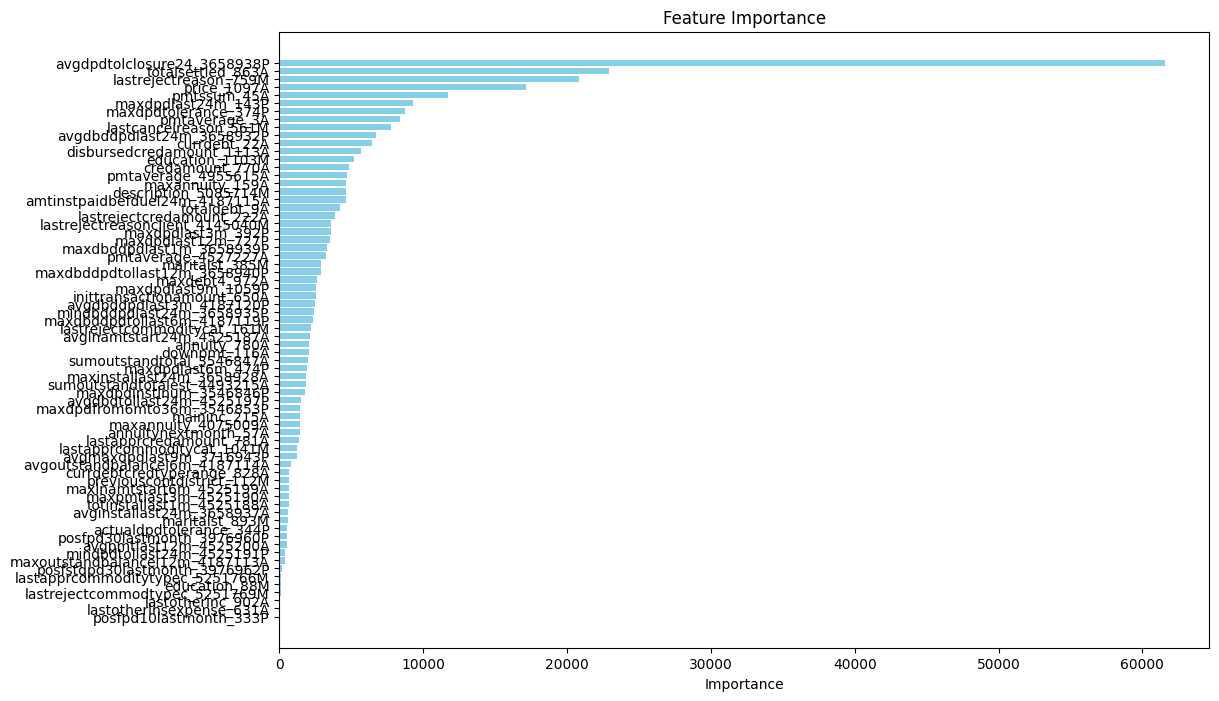

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance
importance = gbm.feature_importance(importance_type='gain')
feature_names = X_train.columns.tolist()
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert axis to have the most important at the top
plt.show()


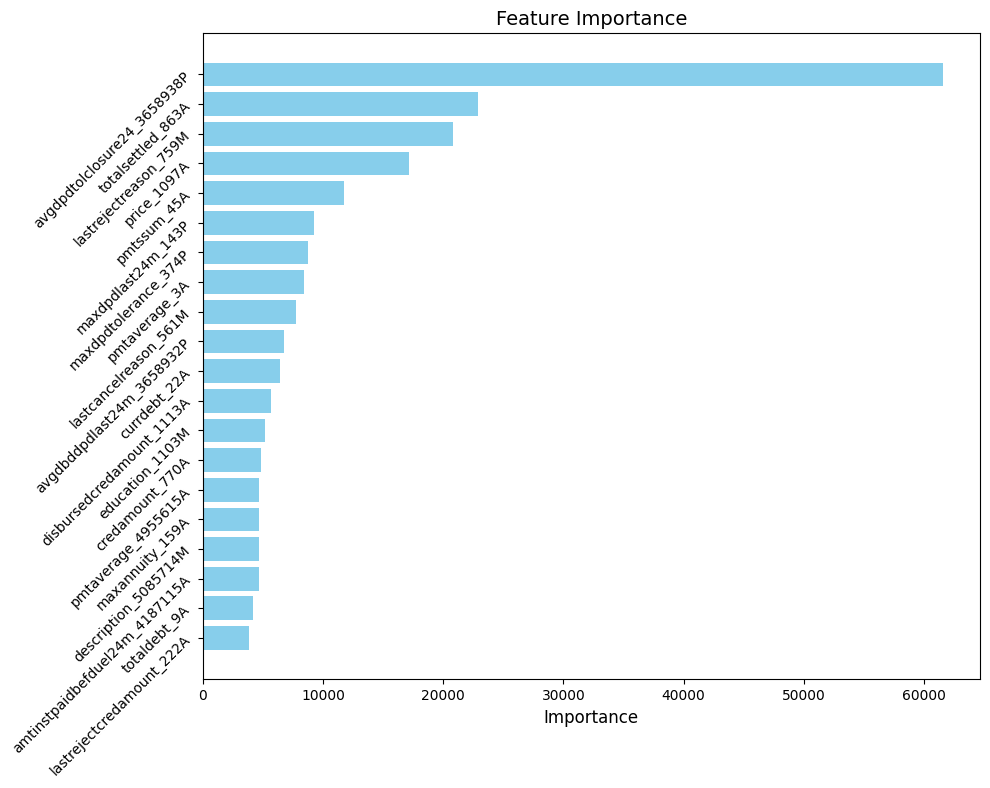

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'importance' and 'feature_names' are as defined before
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Select the top N features for readability
top_features = feature_importance_df.head(20)  # For example, top 20 features

# Plot feature importance
plt.figure(figsize=(10, 8))  # Increase figure size
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance', fontsize=14)

# Invert the y-axis to have the most important feature at the top
plt.gca().invert_yaxis()

# Rotate feature names
plt.yticks(rotation=45, fontsize=10)  # Rotate labels and adjust font size if needed

plt.tight_layout()  # Adjust subplot params for the plot to fit into the figure area.
plt.show()


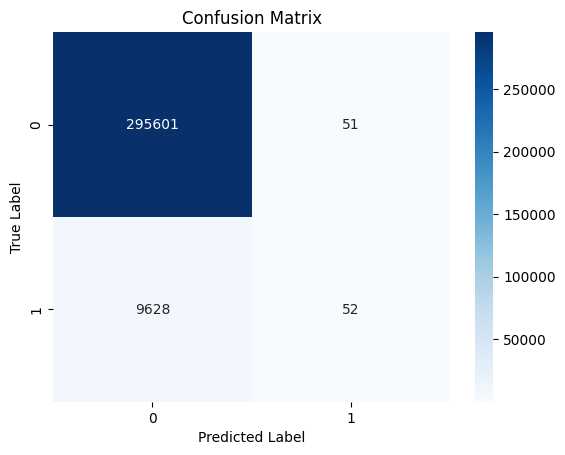

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'base_test' has the true labels in 'target' and predicted scores in 'score'
# You need to convert scores to binary predictions, here using 0.5 as a threshold
threshold = 0.5
y_pred_binary = (base_test['score'] > threshold).astype(int)

cm = confusion_matrix(base_test['target'], y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


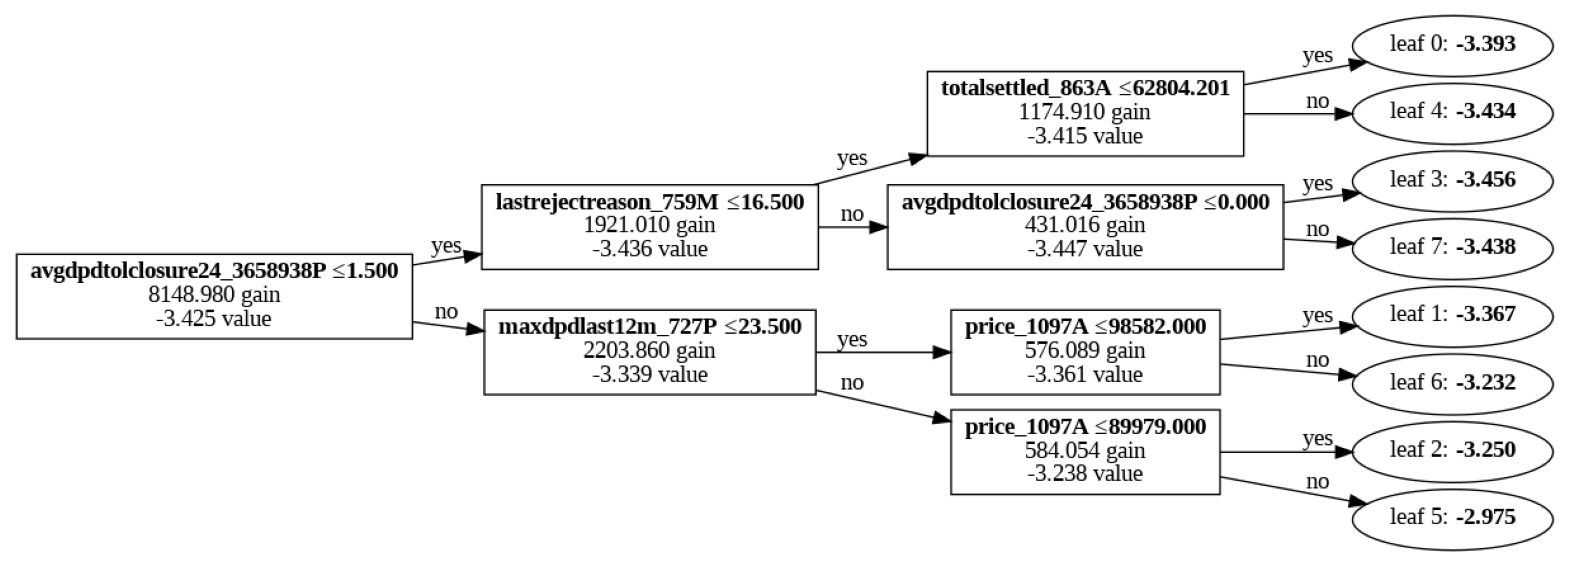

'Digraph.gv.png'

In [ ]:
import lightgbm as lgb

# Plot the first decision tree in the LightGBM model
ax = lgb.plot_tree(gbm, tree_index=0, figsize=(20, 8), show_info=['split_gain', 'internal_value'])
plt.show()

# If you need a higher resolution tree visualization, you may save it to a file and view it externally.
graph = lgb.create_tree_digraph(gbm, tree_index=0, format='png')
graph.render(view=True)


In [ ]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}')
print(f'The stability score on the valid set is: {stability_score_valid}')
print(f'The stability score on the test set is: {stability_score_test}')

The stability score on the train set is: 0.562112479722089
The stability score on the valid set is: 0.5343616743750068
The stability score on the test set is: 0.5210892935596464


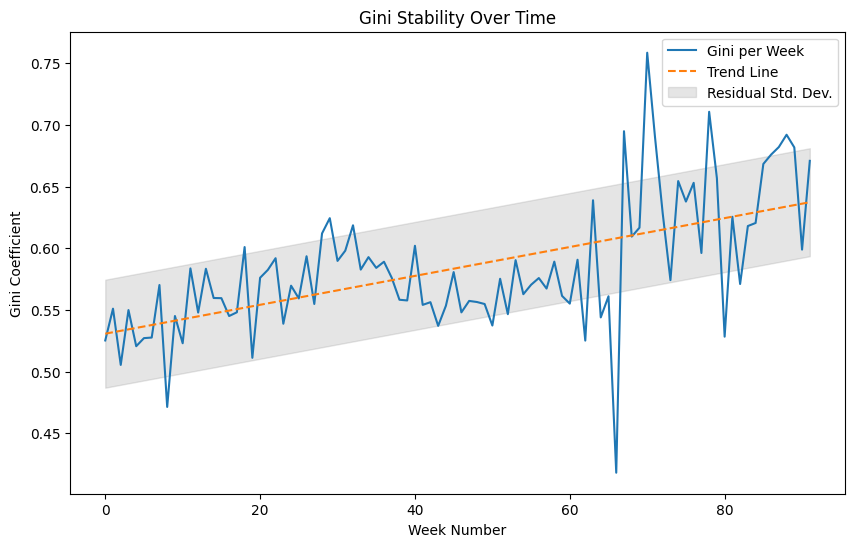

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score

def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5, plot=False):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]] \
        .sort_values("WEEK_NUM") \
        .groupby("WEEK_NUM")[["target", "score"]] \
        .apply(lambda x: 2 * roc_auc_score(x["target"], x["score"]) - 1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)

    stability_score = avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, label='Gini per Week')
        plt.plot(x, y_hat, label='Trend Line', linestyle='--')
        plt.fill_between(x, y_hat - res_std, y_hat + res_std, alpha=0.2, color='gray', label='Residual Std. Dev.')
        plt.title('Gini Stability Over Time')
        plt.xlabel('Week Number')
        plt.ylabel('Gini Coefficient')
        plt.legend()
        plt.show()

    return stability_score

# Call the function with plotting turned on
stability_score_train = gini_stability(base_train, plot=True)
# Repeat for base_valid and base_test as needed


Train Set Gini Stability


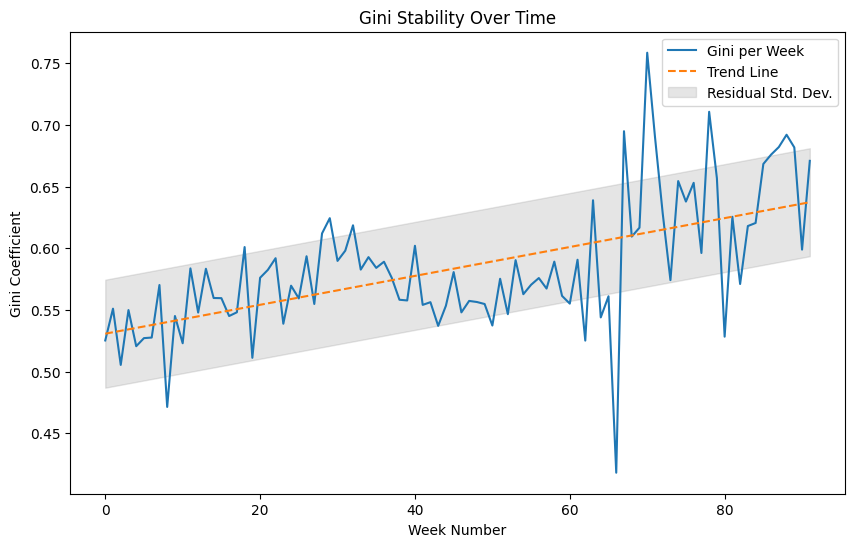

Validation Set Gini Stability


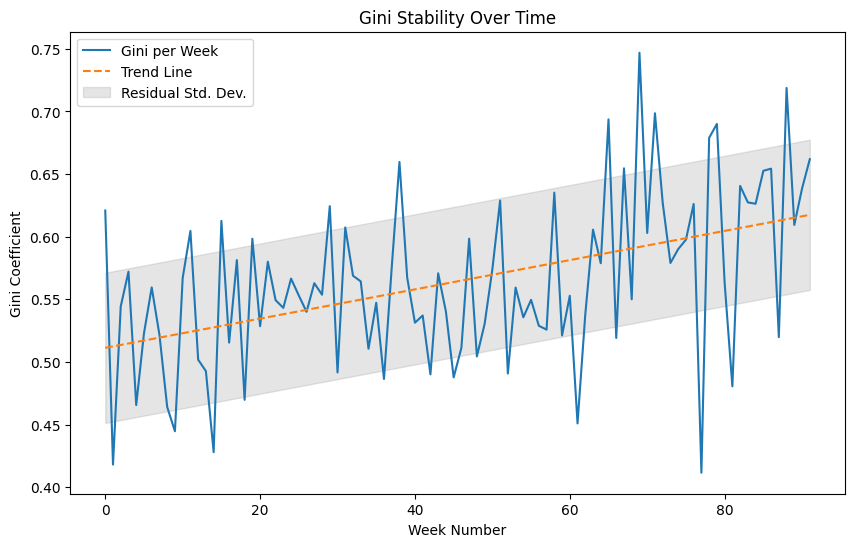

Test Set Gini Stability


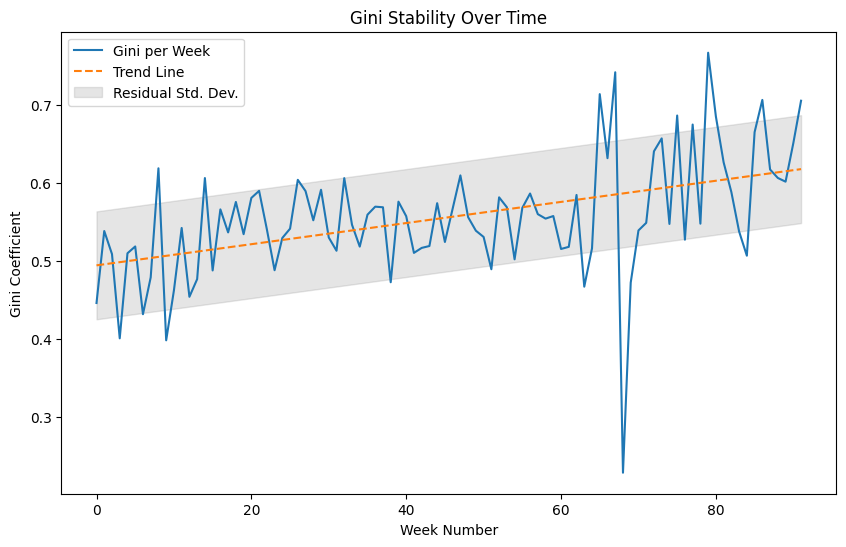

The stability score on the train set is: 0.562112479722089
The stability score on the valid set is: 0.5343616743750068
The stability score on the test set is: 0.5210892935596464


In [ ]:


#call the function for each dataset and plot the Gini stability
print("Train Set Gini Stability")
stability_score_train = gini_stability(base_train, plot=True)

print("Validation Set Gini Stability")
stability_score_valid = gini_stability(base_valid, plot=True)

print("Test Set Gini Stability")
stability_score_test = gini_stability(base_test, plot=True)

# Print out the stability scores
print(f'The stability score on the train set is: {stability_score_train}')
print(f'The stability score on the valid set is: {stability_score_valid}')
print(f'The stability score on the test set is: {stability_score_test}')


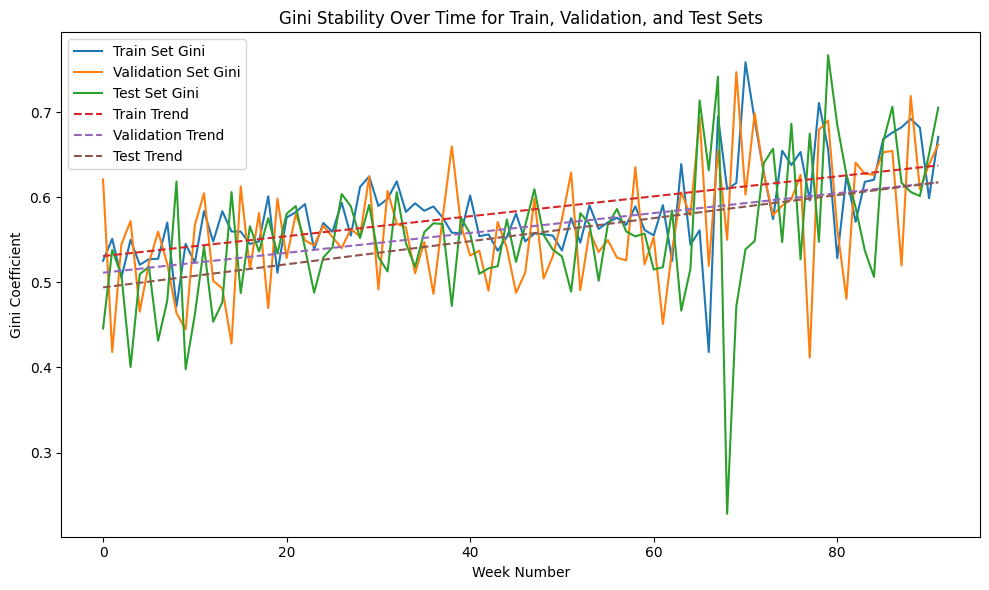

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score

def get_gini_stability(base):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]] \
        .sort_values("WEEK_NUM") \
        .groupby("WEEK_NUM")[["target", "score"]] \
        .apply(lambda x: 2 * roc_auc_score(x["target"], x["score"]) - 1).tolist()
    return gini_in_time

# Calculate Gini coefficients for each dataset
gini_train = get_gini_stability(base_train)
gini_valid = get_gini_stability(base_valid)
gini_test = get_gini_stability(base_test)

# Assuming all datasets have the same WEEK_NUM range
weeks = np.arange(len(gini_train))

plt.figure(figsize=(10, 6))

# Plot Gini coefficients for all three sets
plt.plot(weeks, gini_train, label='Train Set Gini')
plt.plot(weeks, gini_valid, label='Validation Set Gini')
plt.plot(weeks, gini_test, label='Test Set Gini')

# Adding trend lines for each set
for gini_scores, label in zip([gini_train, gini_valid, gini_test], ['Train', 'Validation', 'Test']):
    a, b = np.polyfit(weeks, gini_scores, 1)
    plt.plot(weeks, a*weeks + b, label=f'{label} Trend', linestyle='--')

plt.title('Gini Stability Over Time for Train, Validation, and Test Sets')
plt.xlabel('Week Number')
plt.ylabel('Gini Coefficient')
plt.legend()
plt.tight_layout()
plt.show()



## Submission

Scoring the submission dataset is below, we need to take care of new categories. Then we save the score as a last step.

In [ ]:
X_submission = data_submission[cols_pred].to_pandas()
X_submission = convert_strings(X_submission)
categorical_cols = X_train.select_dtypes(include=['category']).columns

for col in categorical_cols:
    train_categories = set(X_train[col].cat.categories)
    submission_categories = set(X_submission[col].cat.categories)
    new_categories = submission_categories - train_categories
    X_submission.loc[X_submission[col].isin(new_categories), col] = "Unknown"
    new_dtype = pd.CategoricalDtype(categories=train_categories, ordered=True)
    X_train[col] = X_train[col].astype(new_dtype)
    X_submission[col] = X_submission[col].astype(new_dtype)

y_submission_pred = gbm.predict(X_submission, num_iteration=gbm.best_iteration)

In [ ]:
submission = pd.DataFrame({
    "case_id": data_submission["case_id"].to_numpy(),
    "score": y_submission_pred
}).set_index('case_id')
submission.to_csv("./submission.csv")